In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

In [2]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from b2ar_feature_types import *
from get_variable_names import *
from b2ar_tica_config import *
from residue import Residue, Atom

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

#set_palette('Set1', n_colors=15, desat=None)

In [5]:
ori_feature_name = copy.deepcopy(feature_name)

In [6]:
#schemes = ["closest-heavy", "CA"]
#feature_name = "%s-CA" %ori_feature_name

In [7]:
rho = 0.01
rho_string = "_rho0pt01"

In [8]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dirdir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A
/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A


In [9]:
tica_dir

'/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01'

In [10]:
cutoff

0.66

In [57]:
schemes

['closest-heavy', 'CA']

In [51]:
contact_residues

[ASP29,
 GLU30,
 VAL31,
 TRP32,
 VAL33,
 VAL34,
 GLY35,
 MET36,
 GLY37,
 ILE38,
 VAL39,
 MET40,
 SER41,
 LEU42,
 ILE43,
 VAL44,
 LEU45,
 ALA46,
 ILE47,
 VAL48,
 PHE49,
 GLY50,
 ASN51,
 VAL52,
 LEU53,
 VAL54,
 ILE55,
 THR56,
 ALA57,
 ILE58,
 ALA59,
 LYS60,
 PHE61,
 GLU62,
 ARG63,
 LEU64,
 GLN65,
 THR66,
 VAL67,
 THR68,
 ASN69,
 TYR70,
 PHE71,
 ILE72,
 THR73,
 SER74,
 LEU75,
 ALA76,
 CYS77,
 ALA78,
 ASP79,
 LEU80,
 VAL81,
 MET82,
 GLY83,
 LEU84,
 ALA85,
 VAL86,
 VAL87,
 PRO88,
 PHE89,
 GLY90,
 ALA91,
 ALA92,
 HIS93,
 ILE94,
 LEU95,
 MET96,
 LYS97,
 MET98,
 TRP99,
 THR100,
 PHE101,
 GLY102,
 ASN103,
 PHE104,
 TRP105,
 CYS106,
 GLU107,
 PHE108,
 TRP109,
 THR110,
 SER111,
 ILE112,
 ASP113,
 VAL114,
 LEU115,
 CYS116,
 VAL117,
 THR118,
 ALA119,
 SER120,
 ILE121,
 GLU122,
 THR123,
 LEU124,
 CYS125,
 VAL126,
 ILE127,
 ALA128,
 VAL129,
 ASP130,
 ARG131,
 TYR132,
 PHE133,
 ALA134,
 ILE135,
 THR136,
 SER137,
 PRO138,
 PHE139,
 LYS140,
 TYR141,
 GLN142,
 SER143,
 LEU144,
 LEU145,
 THR146,
 LYS147,


In [ ]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, 
                          traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, 
                          structures = [active_ref_dir, inactive_ref_dir], dihedral_residues =  [], 
                          dihedral_types = ["phi", "psi", "chi1", "chi2"], 
                          contact_residues =  contact_residues, residues_map = None, 
                          contact_cutoff = cutoff, parallel = False, 
                          exacycle = exacycle, load_from_file=False, schemes=schemes)


In [ ]:
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True)

In [8]:
tica_object = verboseload(projection_operator_dir)
print(tica_object.timescales_)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
[ 608.76369352  342.82218117  245.50411087  215.63066628  154.69677355
  155.50637752  129.76331383  104.55745741  105.81972363  128.19281613
   98.09798731   77.75059767   72.03939041   63.51776034   65.46962409
   56.51628841   56.55764827   70.05206467   62.57206504   45.93474676
   46.11822305   41.0391746    44.00544067   37.35108      38.67501459]


In [59]:
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A-CA_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
Interpreting tIC 1
feature_importances_df.shape
(4, 7)
residue_importances_df.shape
(7, 3)
          feature_name      res_i      res_j  resid_i  resid_j  importance  \
3  Phe104_Ca-Gln170_Ca  Phe104_Ca  Gln170_Ca      104      170    0.295031   
1         Asp79-Tyr326      Asp79     Tyr326       79      326    0.188006   
0         Asp79-Asn318      Asp79     Asn318       79      318    0.173521   
2   Gly50_Ca-Pro323_Ca   Gly50_Ca  Pro323_Ca       50      323    0.169860   

                  feature  
3  [PHE104_CA, GLN170_CA]  
1         [ASP79, TYR326]  
0         [ASP79, ASN318]  
2   [GLY50_CA, PRO323_CA]  
             residue  importance  resid
Gln170_Ca  Gln170_Ca    0.295031    170
Phe104_Ca  Phe104_Ca    0.295031    104
Tyr326        Tyr326    0.188006    326
Asp79          Asp79    0.187281

In [42]:
tica_coords = verboseload(projected_features_dir)
pnas_coords = verboseload(pnas_coords_dir)
for pnas_coord in pnas_coords: pnas_coord[:,0]*=7.14
tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
pnas_names = ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/b2ar_analysis/all_pnas_features/pnas_coords.h5"...


In [43]:
def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

In [44]:
clusterer = verboseload(clusterer_dir)
cluster_averages = calculate_cluster_averages_per_feature(clusterer, pnas_coords)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_1000clusters.h5"...


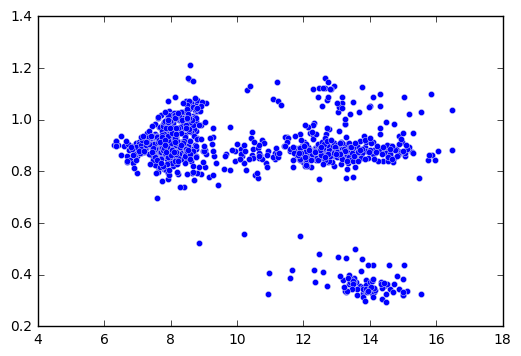

In [46]:
plt.scatter(cluster_averages[:,0], cluster_averages[:,2])

In [70]:
cluster_averages = pd.DataFrame(cluster_averages, columns=pnas_names)
active_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] < 0.5) & (cluster_averages["tm6_tm3_dist"] > 12.) & (cluster_averages["tm6_tm3_dist"] < 15.)]
inactive_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] > 0.5) & (cluster_averages["tm6_tm3_dist"] <10.)]

In [24]:
active_clusters

,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active


In [61]:
import plots
reload(plots)
from plots import *

In [ ]:
plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [ ]:
analysis_dir

In [ ]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [ ]:
get_ligands(agonist_dir)

In [ ]:
get_ligands(biased_agonist_dir)

In [ ]:
docking_multiple_ligands

In [11]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))



143


<AsyncMapResult: chdir>

In [ ]:

indices = [0,1000]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = save_dir
mae_dir = reimaged_dir
remove_ter(reimaged_dir)
reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)


dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



In [ ]:

analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)
compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)

#compute_aggregate_scores(docking_multiple_ligands, inverse_agonists = inverse_ligands, summary = aggregate_docking, z_scores_csv = docking_z_scores_csv)
#aggregate_docking_joined_map = convert_csv_to_joined_map(aggregate_docking, aggregate_docking_joined)[0]
#aggregate_docking_means = calc_mean(aggregate_docking_joined_map)
#write_map_to_csv(aggregate_docking_joined, aggregate_docking_means, ["cluster", "mean_aggregate_docking_z_score"])
#r['do.analysis'](tica_dir, analysis_dir, pnas_coords_csv, tica_coords_csv, features_dir, docking_multiple_ligands)
tics_vs_docking_file = "%s/tICA_vs_docking.pdf" % analysis_dir
plot_tICs_vs_docking(docking_multiple_ligands, tica_coords_csv, tics_vs_docking_file, chosen_ligand="s-carvedilol")


In [25]:
df_agg = pd.read_csv(aggregate_docking)
aggs = df_agg.sort([' nebivolol'], ascending=[0])
aggs.iloc[0:10]

,Unnamed: 0,nebivolol,3p0g_lig,xamoterol,ta-2005,s-carvedilol,isoetharine,r_isopreterenol,r_epinephrine,procaterol
92,cluster193,11.240000,11.900000,9.800000,0.000,11.990000,8.550,7.740000,8.140000,9.090000
554,cluster656,11.234000,10.432000,9.286000,10.093,10.333000,7.123,7.248000,7.204000,8.471000
515,cluster618,10.895000,11.549000,9.323000,8.196,10.764000,7.508,7.924000,7.743000,9.047000
102,cluster201,10.892000,11.375000,9.097000,7.730,10.828000,7.714,7.775000,7.500000,9.234000
616,cluster718,10.855000,10.970000,8.255000,9.920,9.165000,7.150,7.375000,7.260000,9.405000
527,cluster629,10.821429,11.055714,9.795714,0.000,10.261429,8.010,8.494286,7.987143,8.907143
452,cluster558,10.809000,10.462000,8.524000,9.338,9.911000,7.632,7.557000,7.468000,8.703000
420,cluster524,10.796000,10.896000,9.410000,0.000,10.995000,7.793,7.755000,7.377000,8.897000
603,cluster705,10.776000,10.909000,8.690000,7.521,9.536000,7.585,7.687000,7.426000,8.571000
852,cluster953,10.706000,9.771000,8.492000,8.893,9.971000,7.169,7.209000,7.481000,8.610000


In [24]:
np.mean(aggs.values[:,1:], axis=0)

array([9.187068794852921, 9.578267211970433, 8.012728952345569,
       6.789034428359432, 8.855280946194396, 7.048711722699441,
       7.170247644677819, 7.1187833412875055, 8.418875689362489], dtype=object)

In [13]:
tica_clusters = pd.read_csv(tica_coords_csv)

In [36]:
tica_clusters.iloc[6110:6120]

,sample,tIC_0,tIC_1,tIC_2,tIC_3,tIC_4,tIC_5,tIC_6,tIC_7,tIC_8,...,tIC_15,tIC_16,tIC_17,tIC_18,tIC_19,tIC_20,tIC_21,tIC_22,tIC_23,tIC_24
6110,cluster656_sample0,1026.988439,-6.433186,46.120325,-259.456640,138.302319,52.244491,-42.074977,504.288913,29.778034,...,45.029497,63.274585,18.321874,34.696739,-20.044186,70.646061,-88.546949,16.137178,-12.788555,1.635214
6111,cluster656_sample1,716.391351,-71.163450,-19.809763,-186.753198,164.159312,-59.383759,-9.966166,429.128915,44.540477,...,41.064655,90.168818,14.122670,23.154111,-15.981073,94.868514,-89.815575,1.784873,-6.864250,-11.132400
6112,cluster656_sample2,973.697767,-64.380553,25.068903,-297.595853,167.063959,35.659428,2.447084,395.304389,-17.206052,...,104.918684,72.599940,6.872723,24.985984,-12.890263,99.249844,-117.792390,51.043947,9.551392,-0.022773
6113,cluster656_sample3,852.281945,-108.259568,-24.240581,-260.795926,133.878415,13.647492,-0.509626,451.939777,9.376007,...,50.653579,29.996661,17.924472,6.659273,0.513741,83.902844,-78.585894,-0.741896,9.982724,-1.392764
6114,cluster656_sample4,887.455938,-44.150712,-17.968436,-232.714671,149.883716,26.786100,-29.057390,540.974753,-2.432728,...,59.757618,75.276504,20.127226,4.327120,-4.800935,63.204644,-51.381637,10.040043,-5.539995,-6.771137
6115,cluster656_sample5,879.181412,-37.627625,-34.360359,-249.279009,101.835719,41.446110,-28.457874,491.646426,24.226874,...,59.101770,72.458705,22.024073,-11.440090,-24.472129,75.540120,-101.655870,16.048367,6.397225,2.049100
6116,cluster656_sample6,750.636964,9.500870,-53.721380,-128.621558,139.872575,-59.676394,5.291275,498.086412,51.294204,...,42.482837,113.760289,31.213487,38.780715,20.475780,69.193749,-87.570650,28.278385,-27.492919,1.527762
6117,cluster656_sample7,877.318578,-11.467143,-25.856797,-241.188274,133.434943,38.050782,-67.012851,459.772327,27.280786,...,94.905355,66.686012,31.287595,9.519581,-3.010826,90.494922,-114.076033,0.592002,-2.806174,-6.932615
6118,cluster656_sample8,857.697805,-109.279034,19.571371,-226.046692,173.314983,11.194426,17.252183,433.885000,-26.292072,...,44.526014,59.437612,17.585287,31.665348,-32.853240,61.747913,-84.503468,12.808020,19.823839,6.620647
6119,cluster656_sample9,899.222486,-64.331416,43.594528,-259.879115,121.083293,5.245856,-12.229978,418.160837,-26.983009,...,51.916816,46.333081,23.202519,7.327554,-24.330886,73.734238,-54.860263,-1.879874,-5.272219,-11.230973


In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [9]:
lag_time = 10
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_1000clusters.h5"...
fitting msm to trajectories with 1000 clusters and lag_time 10
MSM contains 2 strongly connected components above weight=0.10. Component 1 selected, with population 99.527749%
MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_lag_time10.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 981 states


MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [12]:
n_clusters = 100
n_samples=25

clusterer_tICs_1_2_3_filename = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples.h5" %(tica_dir, n_clusters, n_samples)
clusterer_tICs_1_2_3_map_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_map.json" %(tica_dir, n_clusters, n_samples)
tics_to_cluster = [0, 1, 2]


cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_tICs_1_2_3_filename, tICs=tics_to_cluster)
clusterer_tICs_1_2_3 = verboseload(clusterer_tICs_1_2_3_filename)
clusterer_tICs_1_2_3_map = make_clusters_map(clusterer_tICs_1_2_3)
samples_dir = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
#sample_clusters(clusterer_tICs_1_2_3_filename, projected_features_dir, traj_dir, traj_ext, save_dir=samples_dir, n_samples=n_samples, method = sampling_method, clusters_map_file = clusterer_tICs_1_2_3_map_file, tICs=[0, 1, 2], worker_pool=dview)


Already clustered
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples.h5"...
10901
3672
6212
3168
3177
5384
7894
16445
5192
3866
4044
11575
1385
721
1619
4206
4880
13472
6066
2512
2038
7171
1824
5156
1408
7936
11175
7221
3860
9125
2723
1393
8853
4153
2962
1391
7855
7786
14378
5319
8472
1924
4464
2614
7758
2237
2284
3434
1310
19311
8812
2951
1160
3099
10332
4336
2608
15441
6080
7420
1342
9835
8791
2160
18196
3346
12843
7931
7043
2128
2663
6591
6490
2238
3944
5474
2193
1615
11946
11022
7126
9407
8547
5133
4726
1997
4205
2875
7209
2523
5176
1877
2005
13561
11357
14318
11366
4922
4817
2915


In [134]:
clusterer_tICs_1_2_3_samples = {}
with open(clusters_map_file) as f:
    clusterer_samples = json.load(f)
    clusterer_samples = {int(k):[tuple(vi[0:2]) for vi in v] for k,v in list(clusterer_samples.items())}
#print(clusterer_samples)
original_samples = set()
for key, sample_list in clusterer_samples.iteritems():
    for sample in sample_list:
        original_samples.add(sample)
#print(original_samples)
for cluster_id, sample_list in clusterer_tICs_1_2_3_map.iteritems():
    if cluster_id not in clusterer_tICs_1_2_3_samples.keys():
        clusterer_tICs_1_2_3_samples[cluster_id] = []
    for sample in sample_list:
        if sample in original_samples:
            clusterer_tICs_1_2_3_samples[cluster_id].append(sample)

In [12]:
os.system("source ~/.bash_profile")

0

In [13]:
pprep(mae_dir, ref = active_ref_dir, chosen_receptors = None, worker_pool=dview, parallel=False)

OSError: [Errno 2] No such file or directory: '/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusters1000_n_components25_n_samples10_random_reimaged'

In [ ]:
grid_center = "64.4, 16.9, 11.99"

indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a and "ta" not in a]
print(agonist_ligands)

grid_dir =  "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_grids" %(tica_dir, n_clusters, n_samples)
docking_dir =  "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_docking" %(tica_dir, n_clusters, n_samples)

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)


dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)




biased_ligands
['', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'xamoterol']
['3p0g_lig', 'procaterol', 'r_epinephrine', 'r_isopreterenol']
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_tICs_1_2_3_100clusters_25samples_grids


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)

In [97]:
from msmbuilder.lumping.pcca_plus import PCCAPlus
n_macrostates = 50
lumper = PCCAPlus(n_macrostates)
msm_obj = verboseload(msm_model_dir)
lumper = lumper.from_msm(msm=msm_obj, n_macrostates=n_macrostates)


loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components25all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/msm_lag_time10.h5"...


In [109]:
for cluster in inactive_clusters.index.values:
    if cluster in msm_obj.mapping_.keys():
        microstate = msm_obj.mapping_[cluster]
        macrostate = lumper.microstate_mapping_[microstate]
        if macrostate == 8: print(macrostate)